# Analyzing Agricultural Fields and Temperature Patterns in India using Lonboard

**Table of Contents**

1. [Data Overview](#data-overview)
2. [Loading and Visualizing Geospatial Data](#loading-and-visualizing-geospatial-data)
3. [Extracting Temperature Data from ERA5 Datasets](#extracting-temperature-data-from-era5-datasets)
4. [Processing and Saving ERA5 Data](#processing-and-saving-era5-data)
5. [Extracting Time Series for Field Centroids](#extracting-time-series-for-field-centroids)
6. [Analyzing Temperature Patterns Across Districts](#analyzing-temperature-patterns-across-districts)
7. [Comparing Temperature Patterns Across Multiple Districts](#comparing-temperature-patterns-across-multiple-districts)
8. [Lonboard - Scalable Dynamic Visualization on Maps](#lonboard---scalable-dynamic-visualization-on-maps)


This tutorial demonstrates how to work with geospatial data in Python to analyze agricultural fields and temperature patterns across different districts in India. We'll use libraries like GeoPandas, Xarray, and Matplotlib to:

- Load and visualize field boundaries and district shapefiles.
- Extract temperature time series data from ERA5 datasets.
- Analyze and visualize temperature patterns across selected districts.

## Setup

In [4]:
%%time
import os
from pathlib import Path

data_dir = Path("data")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Mount drive to access data
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install uv
    !uv pip install --system \
        "adlfs>=2024.7.0" \
        "dask>=2024.11.2" \
        "fsspec>=2024.10.0" \
        "geopandas>=1.0.1" \
        "lonboard>=0.10.3" \
        "matplotlib>=3.9.2" \
        "planetary-computer>=1.0.0" \
        "pyarrow>=18.0.0" \
        "pystac-client>=0.8.5" \
        "xarray>=2024.11.0" \
        "zarr>=2.18.3" \
        "odc-stac>=0.3.10" \
        "rasterio>=1.4.2" \
        "rioxarray>=0.18.1" \
        "rasterstats>=0.20.0" \
        "numpy>=2.1.3"

    data_dir = Path("/content/drive/MyDrive/ingarss_workshop_2024")

    print("✅ Environment activated and data ready!")

## Data Overview
We'll be working with:

- Shapefiles for field boundaries and districts in India.
- ERA5 temperature datasets from the Microsoft Planetary Computer.


Make sure you have the necessary data files in your working directory:
- Field boundaries: data/india-crop-boundary/india_10k_fields.shp
- Karnataka districts: data/KA_subdistrict.shp
- Madhya Pradesh districts: data/MP_subdistrict/state_MADHYA PRADESH.shp

## 1. Loading and Visualizing Geospatial Data

First, let's import the required libraries and load the shapefiles.

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import planetary_computer
import xarray as xr
import pystac_client
from datetime import datetime
from shapely.geometry import box

#### Load Field Boundaries and District Shapefiles

In [6]:
# Load field boundaries
fields_gdf = gpd.read_file(f"{data_dir}/india_crop_boundary/india_10k_fields.shp")

# Load district boundaries for Karnataka
karnataka_districts = gpd.read_file(f"{data_dir}/karnataka_district/KA_subdistrict.shp")

In [7]:
fields_gdf.reset_index(inplace=True)

#### Inspect the DataFrames

In [8]:
print("Fields GeoDataFrame shape:", fields_gdf.shape)
print("Karnataka districts shape:", karnataka_districts.shape)

Fields GeoDataFrame shape: (10013, 4)
Karnataka districts shape: (236, 8)


#### Visualize the Districts and Fields

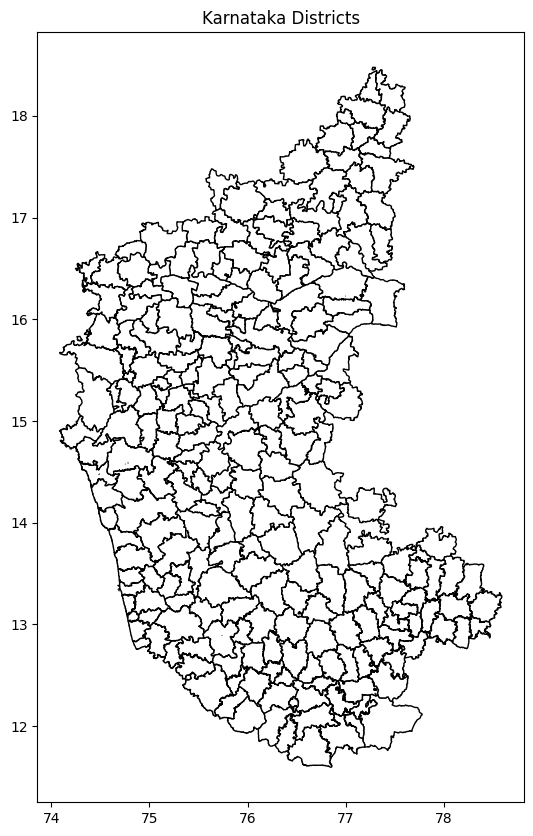

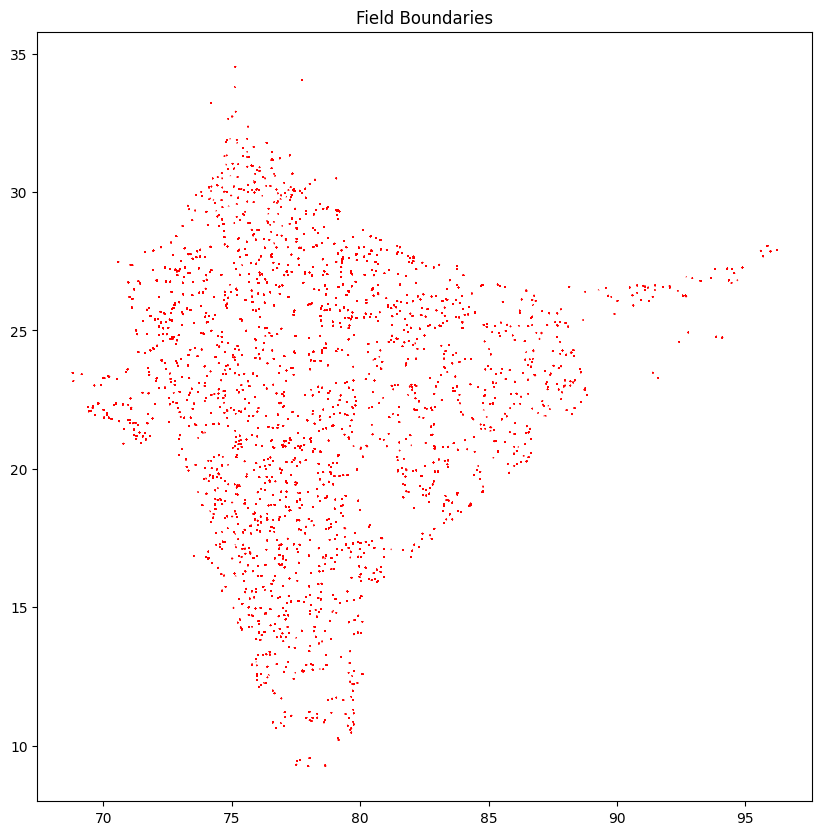

In [9]:
# Plot Karnataka districts
karnataka_districts.plot(figsize=(10, 10), edgecolor='black', facecolor='white')
plt.title('Karnataka Districts')
plt.show()

# Plot field boundaries
fields_gdf.plot(figsize=(10, 10), color='tomato', edgecolor='red')
plt.title('Field Boundaries')
plt.show()

#### Filter to field boundaries in Karnataka

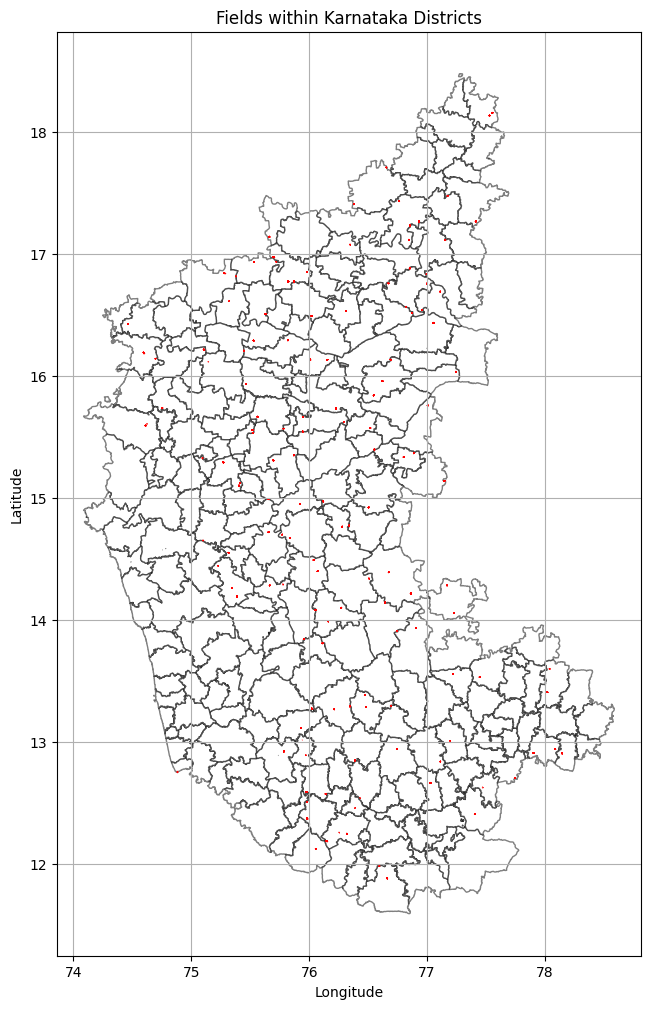

In [10]:
# Ensure both GeoDataFrames have the same CRS
fields_gdf = fields_gdf.to_crs(karnataka_districts.crs)

# Perform spatial join to get fields within Karnataka
fields_karnataka = gpd.sjoin(
    fields_gdf,
    karnataka_districts,
    how='inner',
    predicate='within'
)

# Plot both layers together
fig, ax = plt.subplots(figsize=(12, 12))
karnataka_districts.plot(ax=ax, edgecolor='black', facecolor='white', alpha=0.5)
fields_karnataka.plot(ax=ax, color='tomato', edgecolor='red')
plt.title('Fields within Karnataka Districts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## 2. Extracting Temperature Data from ERA5 Datasets

We'll extract temperature time series data for the fields using ERA5 datasets.

### Load ERA5 Temperature Data

First, we need to access the ERA5 datasets from the Microsoft Planetary Computer.

In [ ]:
# Define spatial and temporal parameters
india_bbox = [68.1, 6.5, 97.4, 37.1]  # Bounding box for India
datetime_range = "2020-01-01/2020-12-31"

# Initialize STAC client
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

# Search for ERA5 data
search = catalog.search(
    collections=["era5-pds"],
    bbox=india_bbox,
    datetime=datetime_range,
    query={"era5:kind": {"eq": "an"}}  # Analysis data only
)

# Fetch matching items
items = search.item_collection()
print(f"Number of matching items: {len(items)}")

Number of matching items: 12


### Load and Concatenate ERA5 Datasets

In [6]:
datasets = []
for item in reversed(items):
    asset = item.assets["air_temperature_at_2_metres"]
    signed_asset = planetary_computer.sign(asset)
    
    ds = xr.open_dataset(
        signed_asset.href,
        **signed_asset.extra_fields.get("xarray:open_kwargs", {})
    ).sel(
        lat=slice(india_bbox[3], india_bbox[1]),
        lon=slice(india_bbox[0], india_bbox[2])
    )
    datasets.append(ds)

# Concatenate datasets along the time dimension
era5_ds = xr.concat(datasets, dim="time")
era5_ds = era5_ds.sortby("time")

### Inspect the Dataset

In [8]:
print(era5_ds)

<xarray.Dataset> Size: 506MB
Dimensions:                      (time: 8784, lat: 123, lon: 117)
Coordinates:
  * lat                          (lat) float32 492B 37.0 36.75 36.5 ... 6.75 6.5
  * lon                          (lon) float32 468B 68.25 68.5 ... 97.0 97.25
  * time                         (time) datetime64[ns] 70kB 2020-01-01 ... 20...
Data variables:
    air_temperature_at_2_metres  (time, lat, lon) float32 506MB dask.array<chunksize=(372, 88, 27), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


## 3. Processing and Saving ERA5 Data

We'll process the ERA5 data by resampling it to daily and weekly means and then save it in Zarr format for efficient access.

### Resample Data to Daily and Weekly Means

In [9]:
# Compute the dataset (load data into memory)
era5_ds = era5_ds.compute()

# Resample to daily mean
era5_daily_ds = era5_ds.resample(time='D').mean()

# Resample to weekly mean
era5_weekly_ds = era5_ds.resample(time='W').mean()

### Save Datasets in Zarr Format

In [10]:
def save_zarr(ds, time_resolution):
    """Save the dataset in Zarr format with appropriate chunking."""
    time_len = len(ds.time)
    chunks = {'time': time_len, 'lat': 1, 'lon': 1}
    encoding = {'air_temperature_at_2_metres': {'chunks': (time_len, 1, 1)}}
    
    output_path = f"{data_dir}/{time_resolution}_air_temperature.zarr"
    print(f"Saving {time_resolution} data to {output_path}")
    ds.to_zarr(output_path, encoding=encoding, mode='w')

# Save datasets
save_zarr(era5_ds, "hourly")
save_zarr(era5_daily_ds, "daily")
save_zarr(era5_weekly_ds, "weekly")

Saving hourly data to data/hourly_air_temperature.zarr
Saving daily data to data/daily_air_temperature.zarr
Saving weekly data to data/weekly_air_temperature.zarr


## 4. Extracting Time Series for Field Centroids

We'll extract temperature time series data for the centroids of selected fields.

### Define a Function to Extract Time Series

In [11]:
def extract_timeseries_for_centroid(ds, geometry, var_name='air_temperature_at_2_metres'):
    """
    Extract a time series from an xarray Dataset using the centroid of a geometry.
    """
    # Get the centroid coordinates
    centroid = geometry.centroid
    lon, lat = centroid.x, centroid.y
    
    # Extract time series using nearest neighbor selection
    point_data = ds[var_name].sel(
        lat=lat,
        lon=lon,
        method='nearest'
    )
    
    # Convert to pandas Series
    time_series = point_data.to_series()
    
    return time_series

### Load the Weekly Dataset

In [12]:
# Load the weekly dataset
ds_weekly = xr.open_zarr(f"{data_dir}/weekly_air_temperature.zarr")

### Extract and Plot Time Series for a Single Field

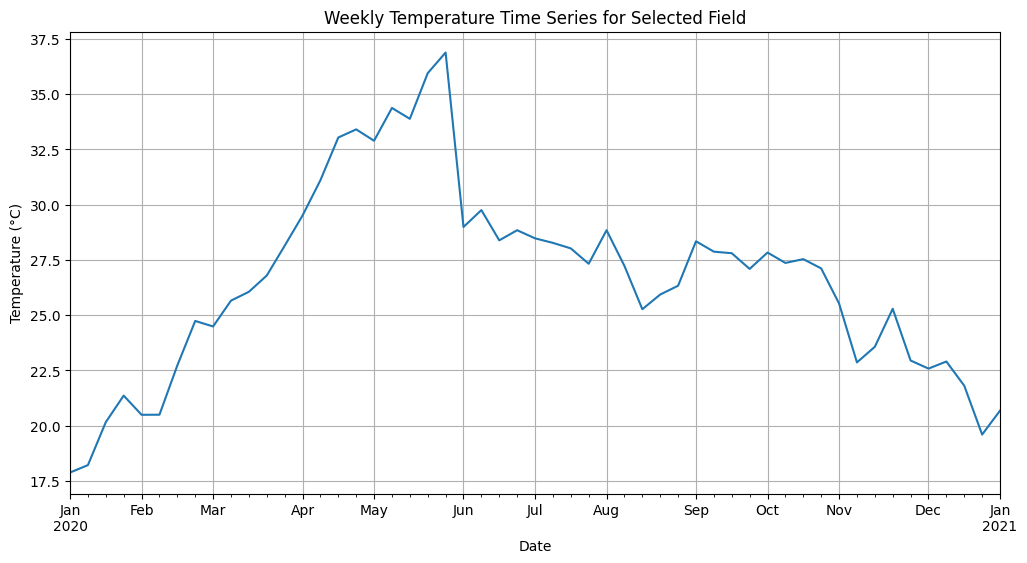

In [13]:
# Select a geometry at random (e.g., the 21st field)
geometry = fields_gdf.geometry.iloc[20]

# Extract time series
ts = extract_timeseries_for_centroid(ds_weekly, geometry)
ts_celsius = ts - 273.15  # Convert from Kelvin to Celsius

# Plot the results
ts_celsius.plot(figsize=(12, 6))
plt.title('Weekly Temperature Time Series for Selected Field')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

## 5. Analyzing Temperature Patterns across fields

We'll analyze temperature patterns across different fields by plotting the temperature time series.

In [14]:
fields_karnataka.shape

(712, 12)

> We have 712 fields mapped in the field boundary dataset.
Note: Not all fields are mapped, but you can use the released model to get all field boundaries in your ROI.

### Define a Function to Plot Time Series for Multiple Fields

In [15]:
def plot_timeseries(fields_df, ds):
    """
    Plot the temperature time series for all fields in a district.
    """
    # Extract time series for all fields
    time_series_list = []
    for _, row in fields_df.iterrows():
        geometry = row.geometry
        ts = extract_timeseries_for_centroid(ds, geometry)
        ts_celsius = ts - 273.15  # Convert from Kelvin to Celsius
        ts.name = f"Field {row.index}"
        time_series_list.append(ts_celsius)
    
    # Combine all series into a DataFrame
    df_temps = pd.concat(time_series_list, axis=1)
    
    # Plot all time series
    plt.figure(figsize=(15, 10))

        # Define season date ranges for 2020
    kharif_start = pd.Timestamp('2020-06-01')
    kharif_end = pd.Timestamp('2020-11-30')
    rabi_start_1 = pd.Timestamp('2020-01-01')
    rabi_end_1 = pd.Timestamp('2020-04-30')
    rabi_start_2 = pd.Timestamp('2020-11-01')
    rabi_end_2 = pd.Timestamp('2020-12-31')
    
    # Create season masks
    kharif_mask = (df_temps.index >= kharif_start) & (df_temps.index <= kharif_end)
    rabi_mask_1 = (df_temps.index >= rabi_start_1) & (df_temps.index <= rabi_end_1)
    rabi_mask_2 = (df_temps.index >= rabi_start_2) & (df_temps.index <= rabi_end_2)
    
    # Plot seasonal backgrounds
    plt.fill_between(df_temps.index[kharif_mask], 
                     df_temps.min().min(), 
                     df_temps.max().max(), 
                     color='green', 
                     alpha=0.1, 
                     label='Kharif Season')
    
    # Plot Rabi season backgrounds
    plt.fill_between(df_temps.index[rabi_mask_1], 
                     df_temps.min().min(), 
                     df_temps.max().max(), 
                     color='orange', 
                     alpha=0.1, 
                     label='Rabi Season')
    plt.fill_between(df_temps.index[rabi_mask_2], 
                     df_temps.min().min(), 
                     df_temps.max().max(), 
                     color='orange', 
                     alpha=0.1)

    plt.plot(df_temps.index, df_temps.values, alpha=0.1, color='lightblue', linewidth=1)
    
    # Plot mean and standard deviation
    mean_temp = df_temps.mean(axis=1)
    std_temp = df_temps.std(axis=1)
    plt.plot(df_temps.index, mean_temp, color='red', linewidth=2, label='Mean Temperature')
    plt.fill_between(df_temps.index,
                     mean_temp - std_temp,
                     mean_temp + std_temp,
                     color='red',
                     alpha=0.2,
                     label='±1 Std Dev')
    
    # Customize plot
    plt.title(f'Weekly Temperature Time Series for Fields in Karnataka (2020)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (C)')
    plt.grid(True, alpha=0.3)
    
    # Adjust legend
    handles, labels = plt.gca().get_legend_handles_labels()
    # Remove duplicate Rabi season from legend
    unique_handles = handles[:4]  # Kharif, Rabi, Mean, Std Dev
    unique_labels = labels[:4]
    plt.legend(unique_handles, unique_labels, loc='upper right')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add season annotations
    y_range = df_temps.max().max() - df_temps.min().min()
    y_pos = df_temps.min().min() + y_range * 0.95
    
    # Print seasonal statistics
    print("\nSeasonal Statistics:")
    
    # Kharif season stats
    kharif_temps = df_temps[kharif_mask]
    print("\nKharif Season (Jun-Nov):")
    print(f"Mean Temperature: {kharif_temps.mean().mean():.2f}K")
    print(f"Std Deviation: {kharif_temps.std().mean():.2f}K")
    
    # Rabi season stats (combining both periods)
    rabi_temps = pd.concat([df_temps[rabi_mask_1], df_temps[rabi_mask_2]])
    print("\nRabi Season (Nov-Apr):")
    print(f"Mean Temperature: {rabi_temps.mean().mean():.2f}K")
    print(f"Std Deviation: {rabi_temps.std().mean():.2f}K")
    
    plt.tight_layout()
    plt.show()


Seasonal Statistics:

Kharif Season (Jun-Nov):
Mean Temperature: 24.99K
Std Deviation: 1.00K

Rabi Season (Nov-Apr):
Mean Temperature: 25.61K
Std Deviation: 2.56K


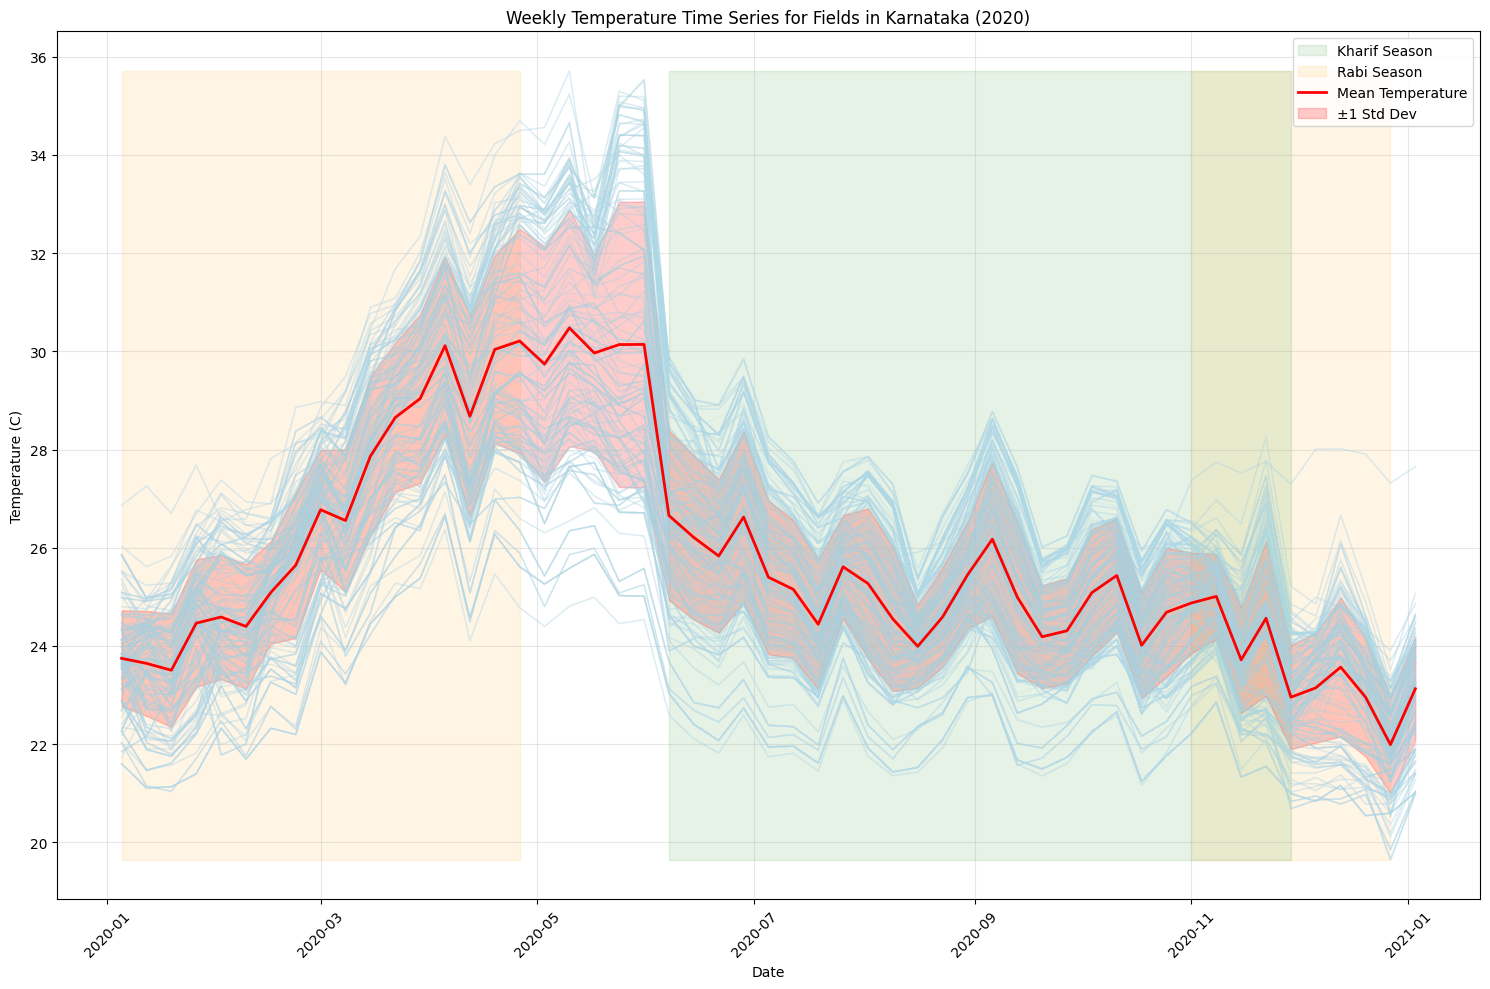

In [16]:
plot_timeseries(fields_karnataka, ds_weekly)

## Lonboard - Scalable Dynamic Visualization on Maps

Lonboard aims to enable visualizing large geospatial datasets interactively through a simple interface inside jupyter notebooks.
It can easily render 10 million points inside your notebook - being built on top of geoarrow & geoparquet. It also utilizes any GPU that is available locally in your system. 

Check example visualizations here: https://developmentseed.org/lonboard/latest/examples/

In [59]:
from lonboard import Map, PolygonLayer

In [68]:
karnataka_layer = PolygonLayer.from_geopandas(
    karnataka_districts,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[240, 240, 240],  # light gray
    get_line_color=[37, 36, 34],  # dark border color
)

fields_layer = PolygonLayer.from_geopandas(
    fields_karnataka,
    get_line_width=2,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[251, 100, 100],  # red
    get_line_color=[37, 36, 34],  # dark border color
)

In [69]:
m = Map(layers=[karnataka_layer, fields_layer])
m

Map(custom_attribution='', layers=(PolygonLayer(get_fill_color=[240, 240, 240], get_line_color=[37, 36, 34], g…